# Librerias

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


#Keras
import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense,BatchNormalization
from keras import initializers
from keras.utils import to_categorical
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
#Sk-Learn
from sklearn.model_selection import train_test_split,ShuffleSplit,GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
ls

2018/
clusterai_2019_clase10_classificacion_NN.ipynb*
clusterai_2019_clase10_classificacion_NN_old.ipynb*
clusterai_2019_clase10_dataset*


# Directorio y DB

In [3]:
#### Classification
carpeta_NN_class = 'NN_Class/'
#DB
file = 'clusterai_2019_clase10_dataset'
df = pd.read_csv(file,index_col=0)
df = df.dropna()
#Col info
categorical = ['xcat1','xcat2']
target= 'y_class'

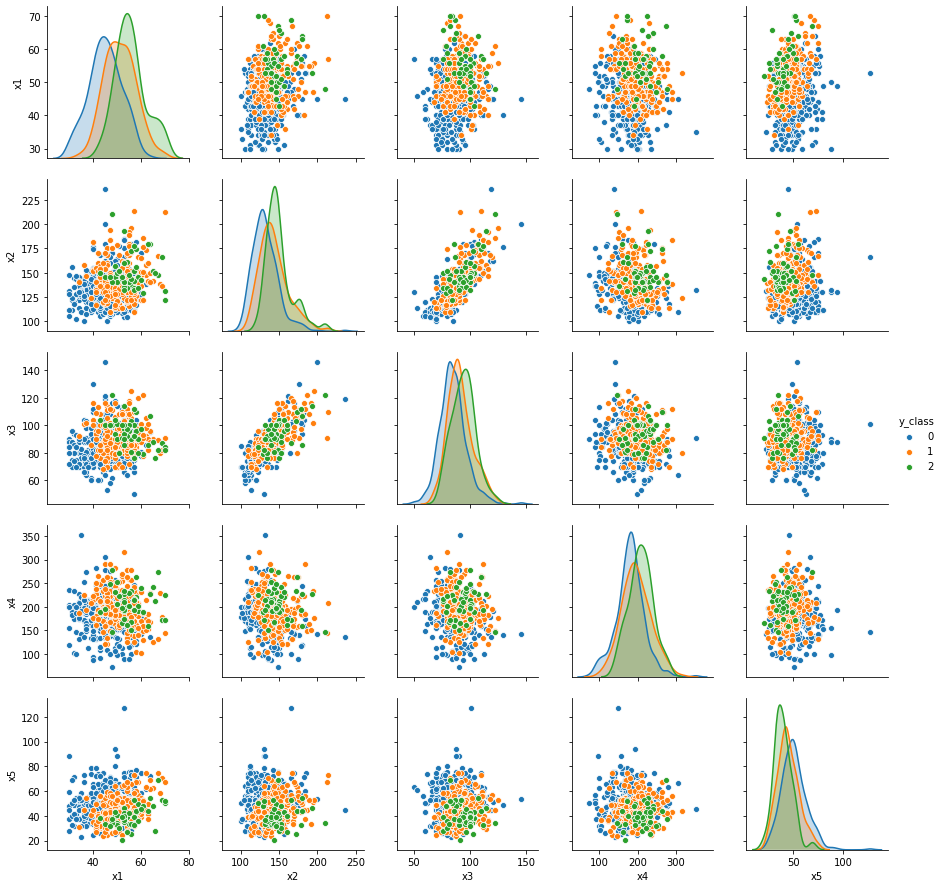

In [4]:
ft = ['x1','x2','x3','x4','x5']
sns.pairplot(df,vars=ft, diag_kind="kde", hue='y_class')
plt.show()

## Clasificar con Redes Neuronales
    * Softmax : Probabilidad [0,1] de pertenecer a la clase Ci
    * Loss : Cross - Entropy
    * Target value ---> Target Vector
    * Metrica: Accuracy
    * Visualizacion del aprendizaje

# Empecemos! !

# Parametros para el GridSearch + CV

* **Proporcion del tamaño del test set** (0,1)

* **Estructura de la Red**: Layers y N° de Neuronas/Layer

* **Funciones de Activacion**

* **Optimizadores**

* **Tamaño del Batch**

* **Cantidad de Epochs**

* **K-Fold**

In [22]:
#Random Seed
r_s=0
#Test size
t_size = 0.2

In [23]:
#Estructura de la Red

#Cantidad de Neuronas por cada Layer
vec_neurons1 = np.array([6,8,10])
vec_neurons2 = np.array([4,6])
vec_neurons3 = np.array([0,6])

In [24]:
#Funciones de Activacion de las neuronas
act_func = ['ReLU','sigmoid']
vec_act_func = ['sigmoid']

In [25]:
#Optimizadores
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax']
vec_optimizer = ['RMSprop']

In [26]:
#Batch
vec_batch_size = [64]

In [27]:
#Epochs
vec_epochs = [50]

In [28]:
#K-Fold
kfold = 3

# Definicion del set de entrenamiento y testeo

**X**

* Normalizamos las variables no categoricas, luego las concatenamos.

**Y**

* La salida de la NN es un vector de dimension "Cantidad de Clases".
Para convertir nuestro "y_clas" (unidimensional) a N-dimensional, usamos la funcion "to_categorical" 

In [29]:
def data(df_orig,categorical,target,t_size,r_s):
    df = df_orig.copy()
    y = df.pop(target).values
    x = df

    x_train, x_test, y_train, y_test = train_test_split(
            x,
            y,
            test_size=t_size, random_state=r_s)
    
    y_train = to_categorical(y_train, num_classes=3)
    y_test = to_categorical(y_test, num_classes=3)

    x_train_no_norm = x_train[categorical].copy()
    x_train = x_train.drop(columns=categorical)
    x_test_no_norm = x_test[categorical].copy()
    x_test = x_test.drop(columns=categorical)

    # Normalizo
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_norm = scaler.transform(x_train)
    x_test_norm = scaler.transform(x_test)
    
    # Concateno
    x_train_norm_full = np.concatenate([x_train_norm, x_train_no_norm], axis=1)
    x_test_norm_full = np.concatenate([x_test_norm, x_test_no_norm], axis=1)
        
    return x_train_norm_full, x_test_norm_full, y_train, y_test

In [30]:
x_train_norm_full, x_test_norm_full, y_train, y_test = data(df,categorical,target,t_size,r_s)

In [31]:
# Dimension de Y
y_train.shape

(494, 3)

# Modelo de NN
Ya que vamos a aplicar un GridSearch, y en cada instancia vamos a generar un modelo, debemos pasarlo como funcion a la que el objeto de SK-Learn pueda llamar cada vez.

En este caso particular, vamos a utilizar un unico "L_rate" = 0.01, pero es otro hiperparametro importante.

In [32]:
def build_model(
    input_size=9,
    neurons1=8, neurons2=8, neurons3=8, neurons4=8,
    activation_f='sigmoid',
    optimizer='rmsprop',
    l_rate=0.01,
    q_clases=3):
    
    K.clear_session() #Para borrar cualquier otro modelo presente

    init_k= keras.initializers.glorot_uniform(seed=0)

    model = Sequential()
    model.add(Dense(neurons1,activation=activation_f, input_shape=(input_size,),kernel_initializer=init_k))
    model.add(BatchNormalization())
    
    if neurons2 >0:
        model.add(Dense((neurons2),activation=activation_f,kernel_initializer=init_k))
        model.add(BatchNormalization())
        
        if neurons3 >0:
            model.add(Dense((neurons3),activation=activation_f,kernel_initializer=init_k))
            model.add(BatchNormalization())
            
            if neurons4 >0:
                model.add(Dense((neurons4),activation=activation_f,kernel_initializer=init_k))
                model.add(BatchNormalization())

    model.add(layers.Dense(q_clases, activation='softmax'))


    if optimizer =='Adam':
        opt = keras.optimizers.Adam(lr=l_rate)
    if optimizer =='RMSprop':
        opt = keras.optimizers.RMSprop(lr=l_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return (model)

In [33]:
def func_NN_class_GS(
        x, y,
        vec_neurons1, vec_neurons2,vec_neurons3,vec_neurons4,
        vec_optimizer,vec_act_func,vec_batch_size, vec_epochs, kfold, t_size):
    # fix random seed for reproducibility
    seed = 0
    i_size = np.shape(x)[1]
    
    print(f"Imput_size{i_size}")    
    cv_cfg = ShuffleSplit(n_splits=kfold, test_size=t_size, random_state=seed)
    
    # Todos los parametros que pertenecen a la grilla,
    # es decir, los hiperparametros en donde vamos a buscar el mejor modelo.
    param_grid = dict(
        input_size=[i_size], epochs=vec_epochs, optimizer=vec_optimizer,activation_f=vec_act_func,
        neurons1=vec_neurons1,neurons2=vec_neurons2,neurons3=vec_neurons3,neurons4=vec_neurons4,
        batch_size=vec_batch_size)

    # Objeto de Sk-Learn
    model = KerasClassifier(build_fn=build_model, verbose=0)
    
    
    grid = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=cv_cfg, verbose=2)
    
    # Entrenamos el objeto
    gs = grid.fit(x, y)
    
    # Print Resultados
    print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
    means_test = gs.cv_results_['mean_test_score']
    stds_test = gs.cv_results_['std_test_score']
    params = gs.cv_results_['params']
    
    # Grid Search Print
    for meants, stdevts, param in zip(means_test, stds_test, params):
        print("Test:%f (%f) with: %r" % (meants, stdevts, param))
    cv_result = gs.cv_results_
    cv_bp = gs.best_params_
    cv_bi = gs.best_index_
    # best_model = gs.best_estimator_.model
    resultado = {
            'cv_result': cv_result, 'best_params': cv_bp, 'best_index': cv_bi}
    return(resultado)  # , best_model)


In [34]:
"""resultado = func_NN_class_GS(
        x_train_norm_full, y_train,
        vec_neurons1, vec_neurons2,vec_neurons3,vec_neurons4,
        vec_optimizer,vec_act_func,vec_batch_size, vec_epochs, kfold, t_size)"""

'resultado = func_NN_class_GS(\n        x_train_norm_full, y_train,\n        vec_neurons1, vec_neurons2,vec_neurons3,vec_neurons4,\n        vec_optimizer,vec_act_func,vec_batch_size, vec_epochs, kfold, t_size)'

In [35]:
def func_GSCV_NN_class(
        df, categorical , target ,       
        vec_neurons1, vec_neurons2, vec_neurons3, vec_neurons4, vec_optimizer,
        vec_act_func,vec_batch_size, t_size, vec_epochs, kfold,r_s):
    
    x_train_norm_full, x_test_norm_full, y_train, y_test = data(df,categorical,target,t_size,r_s)

    resultado = func_NN_class_GS(
        x_train_norm_full, y_train,
        vec_neurons1, vec_neurons2,vec_neurons3,vec_neurons4,
        vec_optimizer,vec_act_func,vec_batch_size, vec_epochs, kfold, t_size)
        
    df = pd.DataFrame(data=resultado)
    #carpeta = 'NN_Class/GS/'
    base_name = str(vec_epochs)+'_'+str(vec_neurons1)+'_'+str(vec_neurons2)+'_'+str(vec_neurons3)+'_'+str(vec_neurons4)
    fname_resultado = base_name+'_resultadoGS.pkl'

    df.to_pickle("./"+fname_resultado)
    K.clear_session()
    return(resultado)

# Ejecucion del GridSearch-CV

In [36]:
resultado = func_GSCV_NN_class(
        df, categorical , target ,       
        vec_neurons1, vec_neurons2, vec_neurons3, vec_neurons4, vec_optimizer,
        vec_act_func,vec_batch_size, t_size, vec_epochs, kfold,r_s)

Imput_size7
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=6, neurons2=4, neurons3=0, neurons4=0, optimizer=RMSprop 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=6, neurons2=4, neurons3=0, neurons4=0, optimizer=RMSprop, total=   1.7s
[CV] activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=6, neurons2=4, neurons3=0, neurons4=0, optimizer=RMSprop 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=6, neurons2=4, neurons3=0, neurons4=0, optimizer=RMSprop, total=   1.8s
[CV] activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=6, neurons2=4, neurons3=0, neurons4=0, optimizer=RMSprop 
[CV]  activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=6, neurons2=4, neurons3=0, neurons4=0, optimizer=RMSprop, total=   1.9s
[CV] activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=6, neurons2=4, neurons3=6, neurons4=0, optimizer=RMSprop 
[CV]  activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=6, neurons2=4, neurons3=6, neurons4=0, optimizer=RMSprop, total=   2.5s
[CV] activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=6, neurons2=4, neurons3=6, neurons4=0, optimizer=RMSprop 
[CV]  activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=6, neurons2=4, neurons3=6, neurons4=0, optimizer=RMSprop, total=   2.5s
[C

[CV]  activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=10, neurons2=6, neurons3=0, neurons4=0, optimizer=RMSprop, total=   1.9s
[CV] activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=10, neurons2=6, neurons3=0, neurons4=0, optimizer=RMSprop 
[CV]  activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=10, neurons2=6, neurons3=0, neurons4=0, optimizer=RMSprop, total=   1.7s
[CV] activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=10, neurons2=6, neurons3=0, neurons4=0, optimizer=RMSprop 
[CV]  activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=10, neurons2=6, neurons3=0, neurons4=0, optimizer=RMSprop, total=   1.8s
[CV] activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=10, neurons2=6, neurons3=6, neurons4=0, optimizer=RMSprop 
[CV]  activation_f=sigmoid, batch_size=64, epochs=50, input_size=7, neurons1=10, neurons2=6, neurons3=6, neurons4=0, optimizer=RMSprop, total=   

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.3min finished


Best: 0.818182 using {'activation_f': 'sigmoid', 'batch_size': 64, 'epochs': 50, 'input_size': 7, 'neurons1': 8, 'neurons2': 6, 'neurons3': 0, 'neurons4': 0, 'optimizer': 'RMSprop'}
Test:0.760943 (0.026512) with: {'activation_f': 'sigmoid', 'batch_size': 64, 'epochs': 50, 'input_size': 7, 'neurons1': 6, 'neurons2': 4, 'neurons3': 0, 'neurons4': 0, 'optimizer': 'RMSprop'}
Test:0.767677 (0.024742) with: {'activation_f': 'sigmoid', 'batch_size': 64, 'epochs': 50, 'input_size': 7, 'neurons1': 6, 'neurons2': 4, 'neurons3': 6, 'neurons4': 0, 'optimizer': 'RMSprop'}
Test:0.794613 (0.017168) with: {'activation_f': 'sigmoid', 'batch_size': 64, 'epochs': 50, 'input_size': 7, 'neurons1': 6, 'neurons2': 6, 'neurons3': 0, 'neurons4': 0, 'optimizer': 'RMSprop'}
Test:0.787879 (0.014285) with: {'activation_f': 'sigmoid', 'batch_size': 64, 'epochs': 50, 'input_size': 7, 'neurons1': 6, 'neurons2': 6, 'neurons3': 6, 'neurons4': 0, 'optimizer': 'RMSprop'}
Test:0.747475 (0.014285) with: {'activation_f': 's

# Mejores parametros del GridSearch

In [37]:
resultado['best_params']

{'activation_f': 'sigmoid',
 'batch_size': 64,
 'epochs': 50,
 'input_size': 7,
 'neurons1': 8,
 'neurons2': 6,
 'neurons3': 0,
 'neurons4': 0,
 'optimizer': 'RMSprop'}

In [43]:
def func_NN_class(
        x, y,
        neurons1, neurons2,neurons3,neurons4,
        optimizer,act_func,batch_size, epochs, kfold, t_size):
    
    #Vectores donde vamos a guardar el progreso en cada epoch
    all_acc_train_hist = []
    all_acc_val_hist = []
    all_acc_test = []

    input_size = np.shape(x)[1]

    for i in range(kfold):
        x_train, x_test, y_train, y_test = train_test_split(
            x,
            y,
            test_size=t_size, random_state=0+i)

        model =build_model(input_size,neurons1,neurons2,neurons3,neurons4,
                            act_func,optimizer)
        history = model.fit(
                x_train, y_train,
                epochs=epochs, batch_size=batch_size, verbose=0,
                validation_data=(x_test, y_test))
        print('- Kfold #'+str(i+1))

        acc_history = history.history['accuracy']
        all_acc_train_hist.append(acc_history)
        val_acc_hist = history.history['val_accuracy']
        all_acc_val_hist.append(val_acc_hist)

        # Results
        test_acc_score, test_acc_score = model.evaluate(x_test, y_test)
        all_acc_test.append(test_acc_score)

    all_acc_test = np.asarray(all_acc_test)
    all_acc_test = all_acc_test.reshape(np.shape(all_acc_test)[0], 1)
    all_acc_train_hist = np.asarray(all_acc_train_hist)
    all_acc_val_hist = np.asarray(all_acc_val_hist)

    return(all_acc_test, all_acc_train_hist, all_acc_val_hist)

In [44]:
#NN
kfold = 10
neurons1 = 8
neurons2 = 6
neurons3 = 0
neurons4 = 0
epochs = 100
act_func = 'relu'
optimizer = 'RMSprop'
batch_size = 64

In [45]:
NN_acc, mean_acc_train, mean_acc_val = func_NN_class(
        x_train_norm_full, y_train,
        neurons1, neurons2,neurons3,neurons4,
        optimizer,act_func,batch_size, epochs, kfold, t_size)

- Kfold #1
99/99 [==============================] - 0s 22us/step
- Kfold #2
99/99 [==============================] - 0s 25us/step
- Kfold #3
99/99 [==============================] - 0s 22us/step
- Kfold #4
99/99 [==============================] - 0s 26us/step
- Kfold #5
99/99 [==============================] - 0s 21us/step
- Kfold #6
99/99 [==============================] - 0s 25us/step
- Kfold #7
99/99 [==============================] - 0s 23us/step
- Kfold #8
99/99 [==============================] - 0s 22us/step
- Kfold #9
99/99 [==============================] - 0s 25us/step
- Kfold #10
99/99 [==============================] - 0s 21us/step


# Resultados

In [46]:
# Acc vs Epochs
test_acc_mean = np.round(np.mean(NN_acc), 2)
test_acc_std = np.round(np.std(NN_acc), 3)
# Train Error
train_acc_mean = np.mean(mean_acc_train, 0)
# Validation Error
val_acc_mean = np.mean(mean_acc_val, 0)
# Epochs
epc = np.arange(1, epochs+1)

print(f'ACC en el modelado NN: \r\n ({test_acc_mean} ~ {test_acc_std})')

ACC en el modelado NN: 
 (0.84 ~ 0.041)


In [47]:
#Para suavizar la grafica
def smooth_curve(points, factor):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Visualizacion: Accuracy vs Epoch

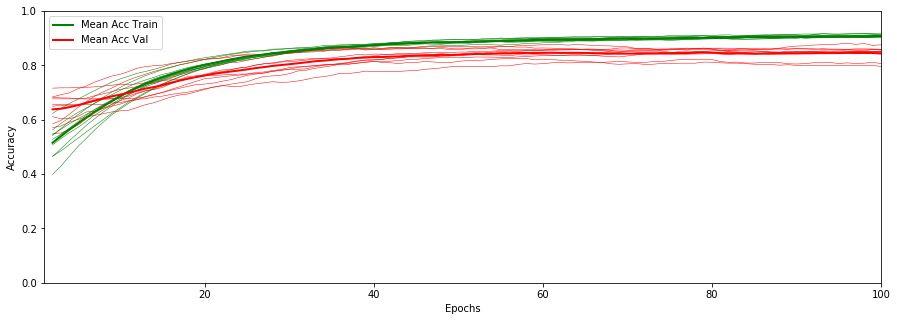

In [48]:
#Epoch Inicial
e_i = 1
factor = 0.9
f, (ax0) = plt.subplots(1, 1, figsize=(15, 5))
for i_k in range(0, kfold):
    # ax0.plot(epc[e_i:], train_mae[i_k, e_i:],'k')
    smooth_acc_kfold = np.asarray(smooth_curve(mean_acc_train[i_k, :], factor)) #Train de cada k-fold
    smooth_val_acc_kfold = np.asarray(smooth_curve(mean_acc_val[i_k, :], factor)) #Validation k-fold
    ax0.plot(epc[e_i:], smooth_acc_kfold[e_i:], 'g', lw=0.5)
    ax0.plot(epc[e_i:], smooth_val_acc_kfold[e_i:], 'r', lw=0.5)
s_tr_acc_mean = np.asarray(smooth_curve(train_acc_mean, factor)) #Train mean
ax0.plot(epc[e_i:], s_tr_acc_mean[e_i:], 'g', lw=2, label='Mean Acc Train')
s_val_acc_mean = np.asarray(smooth_curve(val_acc_mean, factor)) #Val mean
ax0.plot(epc[e_i:], s_val_acc_mean[e_i:], 'r', lw=2, label='Mean Acc Val')
ax0.set_ylim(0, 1)
ax0.set_xlim(1,epochs)
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Accuracy')
ax0.legend()
plt.show()

# Pregunta:

# ¿QUE INFORMACION PODEMOS SACAR DE ESTA GRAFICA?

Recordemos que hasta el momento, solo estuvimos usando el set de entrenamiento para ( "testeamos" con un set de validacion), por lo que una vez que finalizamos el GridSearch + Cross Validation, y con los hiperparametros seleccionados, vamos a **testear formalmente** finalmente nuestro modelo.


Para ello vamos a volver a hacer N repeticiones, pero esta vez vamos a guardar el historial de accuracy para cada K-fold.

De esta manera, vamos a poder visualizar por epochs, como es el avance de nuestro accuracy rate.

In [49]:
input_size = np.shape(x_train_norm_full)[1]
model =build_model(input_size,neurons1,neurons2,neurons3,neurons4,
                            act_func,optimizer)
history = model.fit(
                x_train_norm_full, y_train,
                epochs=epochs, batch_size=batch_size, verbose=0,
                validation_data=(x_test_norm_full, y_test))

In [51]:
acc_history = history.history['accuracy']
acc_test = history.history['val_accuracy']

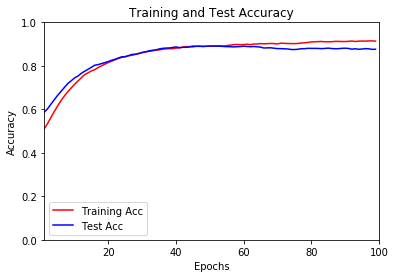

In [54]:
train_acc_history_s = smooth_curve(acc_history, factor,)
test_acc_hist_s = smooth_curve(acc_test, factor)

plt.plot(train_acc_history_s, 'r', label='Training Acc')
plt.plot(test_acc_hist_s, 'b', label='Test Acc')
plt.title('Training and Test Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.xlim([1, epochs])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()